In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# kagip = 'train/'
# datasets = []
# for filenames in os.listdir(path='/kaggle/input'):
#     print('----', filenames)
#     for f in os.listdir(kagip+filenames):
#         datasets.append(os.path.join(filenames,f))
#         print(datasets[-1])

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Setting GPUs

In [4]:
import tensorflow as tf
import os
gpus = tf.config.experimental.list_physical_devices('GPU')
# print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Data Loading as batches and Augmentation

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# root_dir = '/Users/jijnasu/Workspace/OD-WeaponDetection'
train_data_dir = validation_data_dir = test_data_dir = None

train_data_dir = 'train'
# validation_data_dir = f'{root_dir}/intel-image/val'
# test_data_dir = f'{root_dir}/intel-image/val'

def get_data(ims=150, batch_size=32):
    
    augdict = {
        'rotation_range':20,
        'width_shift_range':0.2,
        'height_shift_range':0.2,
        'shear_range':0.2,
        'zoom_range':0.2,
        'horizontal_flip':True,
        'fill_mode':'nearest',
    }

    split = 0.2

    datagen = ImageDataGenerator(
    #     rescale=1.0 / 255,
        # **augdict,
        validation_split=split
    )

    auggen = ImageDataGenerator(
    #     rescale=1.0 / 255,
        **augdict,
        validation_split=split
    )

    valgen = ImageDataGenerator(
    #     rescale=1.0 / 255,
        # **augdict,
        validation_split=split
    )
    testgen = ImageDataGenerator(
    #     rescale=1.0 / 255,
        # **augdict,
    )


    print(end='data_generator:\t')
    data_generator = None
    data_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(ims, ims),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',  # Specify 'training' or 'validation'
        shuffle=True
    )
    
    print(end='aug_generator:\t')
    aug_generator = None
    aug_generator = auggen.flow_from_directory(
        train_data_dir,
        target_size=(ims, ims),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',  # Specify 'training' or 'validation'
        shuffle=True
    )

    print(end='val_generator:\t')
    val_generator = None
    val_generator = valgen.flow_from_directory(
        train_data_dir,
        target_size=(ims, ims),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',  # Specify 'training' or 'validation'
        shuffle=False
    )

    test_generator = None
    if test_data_dir:
        print(end='test_generator:\t')
        test_generator = testgen.flow_from_directory(
            test_data_dir,
            target_size=(ims, ims),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )

    num_classes, nb_train_samples, nb_validation_samples = val_generator.num_classes, len(data_generator.classes), len(val_generator.classes)
    return data_generator, aug_generator, val_generator, test_generator, ims, batch_size, num_classes, nb_train_samples, nb_validation_samples


data_generator, aug_generator, val_generator, test_generator, ims, batch_size, num_classes, nb_train_samples, nb_validation_samples = get_data(224, 32)
# nb_train_samples, nb_validation_samples

data_generator:	Found 2613 images belonging to 4 classes.
aug_generator:	Found 2613 images belonging to 4 classes.
val_generator:	Found 652 images belonging to 4 classes.


# Performance functions
* `plot_multi_loss_acc(histories)`
* `print_f1_acc(model, dataset)`
* `print_multi_f1_acc(models, dataset)`
* `get_np_array_from_gen(generator, num)`
* `print_layers_of_model(model)`
* `get_class_weights(generator)`
* `callbacks`

In [7]:
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import numpy as np
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight

def plot_multi_loss_acc(histories):
    fig = plt.figure(figsize=(12,7))
    for i,hist in enumerate(histories):
        keys = list(hist.history.keys())
        plt.subplot(1,2,1)
        plt.plot(hist.history[keys[0]], label=f'loss{i+1}', linestyle='--') # color = 'orange'
        plt.plot(hist.history[keys[2]], label=f'v_loss{i+1}') # color = 'orange'
        plt.title('Loss', fontsize=20)
        plt.legend(loc="upper right")
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(hist.history[keys[1]], label=f'acc{i+1}', linestyle='--') # color = 'orange'
        plt.plot(hist.history[keys[3]], label=f'v_acc{i+1}') # color = 'orange'
        plt.title('Accuracy', fontsize=20)
        plt.legend(loc="lower right")
        plt.grid(True)
        
        plt.tight_layout()
    plt.show()
    return fig
    
    
def print_f1_acc(model, dataset):
    true_labels = np.array(dataset.classes)
    predictions = model.predict(dataset)
    pred_labels = predictions.argmax(axis=1)
    f1 = f1_score(true_labels, pred_labels, average='macro')
    acc = accuracy_score(true_labels, pred_labels)
    print(f"Accuracy = \t{acc*100}%\nF1-score = \t{f1}")
    return f1, acc


def print_multi_f1_acc(models, dataset):
    true_labels = np.array(dataset.classes)
    all_predictions = []
    for i,model in enumerate(models):
        print(f'\nModel: {i+1}')
        predictions = model.predict(dataset)
        all_predictions.append(predictions)
        pred_labels = predictions.argmax(axis=1)
        f1 = f1_score(true_labels, pred_labels, average='macro')
        acc = accuracy_score(true_labels, pred_labels)
        print(f"Accuracy = \t{acc*100}%\nF1-score = \t{f1}")
        all_predictions.append(predictions)
    predictions = np.array(all_predictions)
    predictions = predictions.sum(axis = 0)
    pred_labels = predictions.argmax(axis=1)
    f1 = f1_score(true_labels, pred_labels, average='macro')
    acc = accuracy_score(true_labels, pred_labels)
    print(f"\n{'-'*30}\nFinal Ensemble:\nAccuracy = \t{acc*100}%\nF1-score = \t{f1}")
    return f1, acc
    
def get_np_array_from_gen(generator, num):
    X = []
    y = []
    for b in generator:
        X.extend(b[0])
        y.extend(b[1])
        if len(X)>=num: break
    return np.array(X), np.array(y)

def print_layers_of_model(model):
    for i,layer in enumerate(model.layers):
        print(i+1, layer.name)

def get_class_weights(generator):
    class_weights = compute_class_weight('balanced', classes=np.unique(generator.classes), y=generator.classes)
    class_weights = dict((k,v) for k,v in enumerate(class_weights))
    return class_weights



# callbacks
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
checkpoint = tf.keras.callbacks.ModelCheckpoint("effnet.h5",monitor="val_categorical_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_categorical_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=8,
    min_delta=0.001,
    restore_best_weights=True,
)

# print(get_class_weights(train_generator))
# plt.hist(train_generator.classes)

# EDA

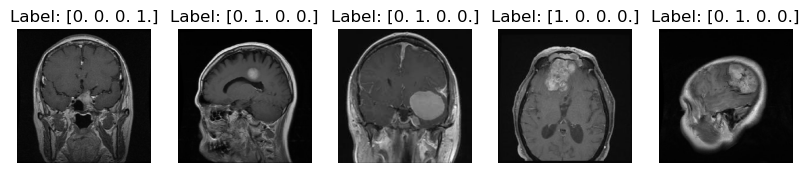

In [8]:
import matplotlib.pyplot as plt

# Print a few generated images for visualization
num_samples_to_display = 5

# Get a batch of images and labels from the data generator
images, labels = next(data_generator)

# Display the images and their labels
plt.figure(figsize=(10, 10))
for i in range(num_samples_to_display):
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(images[i]/255)
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()

{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}
[0 1 2 3] [741 750 401 721]


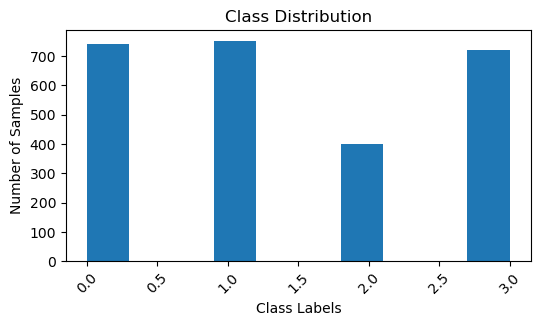

In [47]:
category_name = dict((k,v) for v,k in data_generator.class_indices.items())
print(category_name)
class_labels = data_generator.classes
unique_classes, class_counts = np.unique(class_labels, return_counts=True)
print(unique_classes, class_counts)
plt.figure(figsize=(6, 3))
plt.hist( data_generator.classes)#, bins=num_classes)
plt.title('Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
# plt.grid(True)
plt.show()

# Fitting to Models
### All packages

In [10]:
import random
import tensorflow as tf
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers.experimental import preprocessing

### CNN model

In [ ]:
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
#     import tensorflow as tf
#     from tensorflow.keras import layers, models

#     # Define the CNN architecture
#     model = models.Sequential()

#     # First convolutional layer
#     model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(ims, ims, 3)))
#     model.add(layers.MaxPooling2D((2, 2)))

#     # Second convolutional layer
#     model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))

#     # Third convolutional layer
#     model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))

#     # Flatten the output of the convolutional layers
#     model.add(layers.Flatten())

#     # Fully connected layers
#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.Dense(4, activation='softmax'))  # Assuming 10 classes for classification

#     # Compile the model
#     model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])


In [ ]:
# # Train the model
# with strategy.scope():
#     history = model.fit(
#         data_generator,
#         steps_per_epoch=len(data_generator),
#         epochs=100,
#         validation_data=val_generator,
#         validation_steps=len(val_generator),
#         callbacks=[early_stopping],
#     )

### Some pre-trained models to test

* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* DenseNet121
* EfficientNet
    * EfficientNetB0 - (224, 224, 3)
    * EfficientNetB1 - (240, 240, 3)
    * EfficientNetB2 - (260, 260, 3)
    * EfficientNetB3 - (300, 300, 3)
    * EfficientNetB4 - (380, 380, 3)
    * EfficientNetB5 - (456, 456, 3)
    * EfficientNetB6 - (528, 528, 3)
    * EfficientNetB7 - (600, 600, 3)

In [41]:

# path to the model weights files.
# root_dir = '/Users/jijnasu/Workspace/OD-WeaponDetection'
root_dir = './'

try:
    os.mkdir(f'{root_dir}/models/')
    print('models created')
except:
    pass
try:
    os.mkdir(f'{root_dir}/models/new_way/')
    print('models/new_way created')
except:
    pass
try:
    os.mkdir(f'{root_dir}/models/old_way/')
    print('models/old_way created')
except:
    pass

ims = 260
# Data Loading
data_generator, aug_generator, val_generator, test_generator, ims, batch_size, num_classes, nb_train_samples, nb_validation_samples = get_data(ims, 32)

model_name = 'EfficientNetB2'
# ims = ims
img_width, img_height = ims, ims

# train_data_dir = f'{root_dir}/Knife classification/'
# validation_data_dir = f'{root_dir}/intel-image/val'
# nb_train_samples = batch_size
# nb_validation_samples = batch_size
# epochs = 3
# batch_size = batch_size
models_dir = f'{root_dir}/models/new_way/'
# bottlenech_model_weights_path = f'{models_dir}{model_name}_{nb_train_samples}_bottleneck_fc_model.h5'
top_trained_model_weights_path = f'{models_dir}{model_name}_{nb_train_samples}_top_trained_fc_model.h5'
fine_tuned_model_weights_path = f'{models_dir}{model_name}_{nb_train_samples}_fine_tuned_fc_model.h5'



from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    def get_model():
        data_augmentation = tf.keras.Sequential([
            layers.RandomCrop(height=224, width=224),      
            layers.RandomFlip("horizontal_and_vertical"),  
            layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  
            layers.RandomRotation(factor=0.2),              
            layers.RandomZoom(height_factor=0.2, width_factor=0.2),  
            layers.RandomContrast(factor=0.2),              
            layers.RandomBrightness(factor=0.2)             
        ])

        base_model = keras.applications.EfficientNetB2(
            weights="imagenet",
            input_shape=(ims, ims, 3),
            include_top=False,
        )

        # Freeze the base_model
        # base_model.trainable = False

        # scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
        # scale_layer = tf.keras.applications.resnet.preprocess_input


        # Create new model on top
        x = inputs = keras.Input(shape=(ims, ims, 3))
        # x = data_augmentation(inputs)
        # x = scale_layer(x)
        x = base_model(x)
        x = keras.layers.GlobalAveragePooling2D()(x)
        # x = keras.layers.Dense(1024, activation='relu')(x)
        x = keras.layers.Dropout(0.5)(x)
        # x = keras.layers.Dense(256, activation='relu')(x)
        outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
        model = keras.Model(inputs, outputs)



    #     model = Sequential()
    #     model.add(base_model)
    #     model.add(GlobalAveragePooling2D())
    # #     model.add(Dense(900, activation='relu', kernel_regularizer=l2(0.001)))
    #     model.add(Dropout(0.5))
    # #     model.add(Dense(200, activation='relu'))#, kernel_regularizer=l2(0.001)))
    #     model.add(Dense(num_classes, activation='softmax'))



        return model

    model = get_model()
    print(model.summary())
    
    # model.compile(
    #     optimizer=keras.optimizers.Adam(),
    #     loss=keras.losses.CategoricalCrossentropy(),
    #     metrics=[keras.metrics.CategoricalAccuracy()],
    # )

    # epochs = 100
    # generator = aug_generator
    # history = model.fit(
    #             generator,
    #             steps_per_epoch=nb_train_samples//batch_size,
    #             epochs=epochs, 
    #             validation_data=val_generator,
    #             validation_steps=nb_validation_samples//batch_size,
    #             callbacks=[early_stopping, reduce_lr]
    #         )
    # model.save_weights(top_trained_model_weights_path)




data_generator:	Found 2613 images belonging to 4 classes.
aug_generator:	Found 2613 images belonging to 4 classes.
val_generator:	Found 652 images belonging to 4 classes.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 260, 260, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, 9, 9, 1408)       7768569   
                                                                 
 global_average_pooling2d_1   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1408)              0         
                                                  

In [ ]:

fig = plot_multi_loss_acc([history])
print_f1_acc(model, val_generator)

In [ ]:
base_layer_idx = 1
from_layer = 0
fine_tuned_model_weights_path = f'{models_dir}{model_name}_{nb_train_samples}_{from_layer}_fine_tuned_fc_model.h5'
# model.layers[base_layer_idx].trainable = True
# model.load_weights(top_trained_model_weights_path)

# model.layers[base_layer_idx].trainable = True
# for li in range(0,from_layer):#,len(model.layers[base_layer_idx].layers)):
#     model.layers[base_layer_idx].layers[li].trainable = False

with strategy.scope():
    model.summary()
    model.compile(
        optimizer=keras.optimizers.Adam(4e-6),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.CategoricalAccuracy()],
    )

    epochs = 20
    history = model.fit(
                generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs, 
                validation_data=val_generator,
                validation_steps=nb_validation_samples//batch_size,
                callbacks=[early_stopping, reduce_lr]
            )
    # model.save_weights(fine_tuned_model_weights_path)

In [ ]:
fig = plot_multi_loss_acc([history])
print_f1_acc(model, val_generator)

# Deploy Model using Gradio

In [31]:
%load_ext gradio
%load_ext numpy


The gradio extension is already loaded. To reload it, use:
  %reload_ext gradio
The numpy module is not an IPython extension.


In [40]:
# %%blocks

import gradio as gr
import numpy as np

def flip_image(x):
    return np.fliplr(x)

with gr.Blocks() as demo:
    with gr.Row():
        image_input = gr.Image()
        image_output = gr.Image()
    image_button = gr.Button("Flip")
    image_button.click(flip_image, image_input, image_output)

demo.launch()

Running on local URL:  http://127.0.0.1:7873

To create a public link, set `share=True` in `launch()`.


In [23]:
demo.close()